In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Function to load an image and transform it into a tensor
def load_image(img_path, transform=None, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    if max_size:
        size = max(max_size, max(image.size))
        image.thumbnail((size, size), Image.LANCZOS)

    if shape:
        size = shape
    else:
        size = max(image.size)

    if transform:
        image = transform(image).unsqueeze(0)

    return image


# Function to convert a tensor to an image
def im_convert(tensor):
    image = tensor.clone().detach().cpu().numpy()
    image = image.squeeze(0)
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image



In [ ]:
# Load the pre-trained VGG19 model
vgg = models.vgg19(pretrained=True).features

# Freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 81.9MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Load the content image
content_img_path = '/content/train_1.jpg'
content_image = load_image(content_img_path, transform)


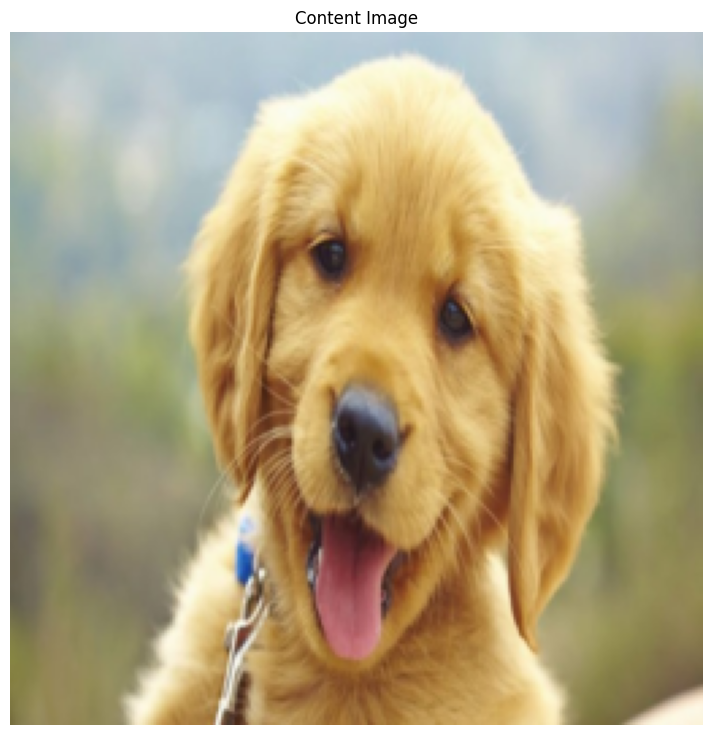

In [ ]:
# Display the content image
content_image_disp = im_convert(content_image)
plt.figure(figsize=(9, 9))
plt.imshow(content_image_disp)
plt.axis('off')
plt.title('Content Image')
plt.show()

In [ ]:
# Split the content image into four quadrants
_, _, height, width = content_image.shape
content_image_top_left = content_image[:, :, :height//2, :width//2]
content_image_top_right = content_image[:, :, :height//2, width//2:]
content_image_bottom_left = content_image[:, :, height//2:, :width//2]
content_image_bottom_right = content_image[:, :, height//2:, width//2:]

# Load the style images
style1_img_path = '/content/art_1.jpg'
style2_img_path = '/content/art_3.jpg'
style3_img_path = '/content/art_2.jpg'
style4_img_path = '/content/art_7.jpg'

style1_image = load_image(style1_img_path, transform, shape=content_image_top_left.shape[-2:])
style2_image = load_image(style2_img_path, transform, shape=content_image_top_right.shape[-2:])
style3_image = load_image(style3_img_path, transform, shape=content_image_bottom_left.shape[-2:])
style4_image = load_image(style4_img_path, transform, shape=content_image_bottom_right.shape[-2:])

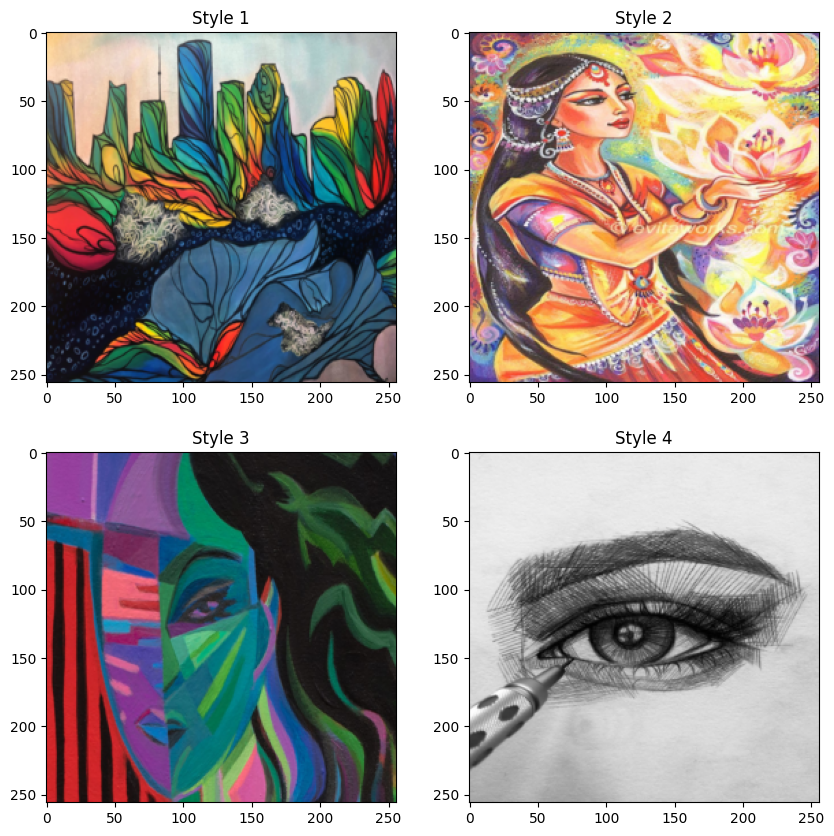

In [ ]:
# Display the style images
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(im_convert(style1_image))
plt.title('Style 1')
plt.subplot(2, 2, 2)
plt.imshow(im_convert(style2_image))
plt.title('Style 2')
plt.subplot(2, 2, 3)
plt.imshow(im_convert(style3_image))
plt.title('Style 3')
plt.subplot(2, 2, 4)
plt.imshow(im_convert(style4_image))
plt.title('Style 4')
plt.show()


In [ ]:
# Function to get the features of an image
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # Content layer
            '28': 'conv5_1'
        }

    # Move the image to the same device as the model
    device = next(model.parameters()).device  # Get the device of the model
    image = image.to(device)  # Move the image to the device

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [ ]:
# Get the content and style features
content_features_top_left = get_features(content_image_top_left, vgg)
content_features_top_right = get_features(content_image_top_right, vgg)
content_features_bottom_left = get_features(content_image_bottom_left, vgg)
content_features_bottom_right = get_features(content_image_bottom_right, vgg)

style1_features = get_features(style1_image, vgg)
style2_features = get_features(style2_image, vgg)
style3_features = get_features(style3_image, vgg)
style4_features = get_features(style4_image, vgg)

In [ ]:
# Calculate the Gram Matrix of a given tensor
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Get the Gram Matrices for each style layer
style1_grams = {layer: gram_matrix(style1_features[layer]) for layer in style1_features}
style2_grams = {layer: gram_matrix(style2_features[layer]) for layer in style2_features}
style3_grams = {layer: gram_matrix(style3_features[layer]) for layer in style3_features}
style4_grams = {layer: gram_matrix(style4_features[layer]) for layer in style4_features}

# Create target images for each quadrant
target_top_left = content_image_top_left.clone().requires_grad_(True).to(device)
target_top_right = content_image_top_right.clone().requires_grad_(True).to(device)
target_bottom_left = content_image_bottom_left.clone().requires_grad_(True).to(device)
target_bottom_right = content_image_bottom_right.clone().requires_grad_(True).to(device)

In [ ]:
# Define the style and content weights
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

# Create target images for each quadrant and detach them from the computation graph
target_top_left = content_image_top_left.clone().detach().to(device)
target_top_right = content_image_top_right.clone().detach().to(device)
target_bottom_left = content_image_bottom_left.clone().detach().to(device)
target_bottom_right = content_image_bottom_right.clone().detach().to(device)

# Make the target images leaf tensors by recreating them
target_top_left = torch.tensor(target_top_left.data, requires_grad=True, device=device)  # Recreate as leaf tensor
target_top_right = torch.tensor(target_top_right.data, requires_grad=True, device=device)  # Recreate as leaf tensor
target_bottom_left = torch.tensor(target_bottom_left.data, requires_grad=True, device=device)  # Recreate as leaf tensor
target_bottom_right = torch.tensor(target_bottom_right.data, requires_grad=True, device=device)  # Recreate as leaf tensor

# Define the optimizer for each quadrant
optimizer_top_left = optim.Adam([target_top_left], lr=0.003)
optimizer_top_right = optim.Adam([target_top_right], lr=0.003)
optimizer_bottom_left = optim.Adam([target_bottom_left], lr=0.003)
optimizer_bottom_right = optim.Adam([target_bottom_right], lr=0.003)

<ipython-input-38-8794f9856389>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_top_left = torch.tensor(target_top_left.data, requires_grad=True, device=device)  # Recreate as leaf tensor
<ipython-input-38-8794f9856389>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_top_right = torch.tensor(target_top_right.data, requires_grad=True, device=device)  # Recreate as leaf tensor
<ipython-input-38-8794f9856389>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_bottom_left = torch.tensor(target_bottom_left.data, require

In [ ]:

# Define the number of steps
steps = 5000

In [ ]:

# Function to perform style transfer on a quadrant
def style_transfer(target, content_features, style_grams, optimizer, vgg):
    for step in range(1, steps+1):
        target_features = get_features(target, vgg)
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            style_gram = style_grams[layer]
            _, d, h, w = target_feature.shape
            style_loss += style_weights[layer] * torch.mean((target_gram - style_gram)**2)

        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if step % 500 == 0:
            print('Step {}: Total loss: {}'.format(step, total_loss.item()))


In [ ]:
# Perform style transfer on each quadrant
style_transfer(target_top_left, content_features_top_left, style1_grams, optimizer_top_left, vgg)
style_transfer(target_top_right, content_features_top_right, style2_grams, optimizer_top_right, vgg)
style_transfer(target_bottom_left, content_features_bottom_left, style3_grams, optimizer_bottom_left, vgg)
style_transfer(target_bottom_right, content_features_bottom_right, style4_grams, optimizer_bottom_right, vgg)

# Convert the target images to a format suitable for display
final_top_left = im_convert(target_top_left.cpu())
final_top_right = im_convert(target_top_right.cpu())
final_bottom_left = im_convert(target_bottom_left.cpu())
final_bottom_right = im_convert(target_bottom_right.cpu())

Step 500: Total loss: 195044229251072.0
Step 1000: Total loss: 91403438784512.0
Step 1500: Total loss: 57190396198912.0
Step 2000: Total loss: 42309479563264.0
Step 2500: Total loss: 33835752357888.0
Step 3000: Total loss: 28129930248192.0
Step 3500: Total loss: 23922846203904.0
Step 4000: Total loss: 20632376967168.0
Step 4500: Total loss: 18031310798848.0
Step 5000: Total loss: 15910278529024.0
Step 500: Total loss: 178542679687168.0
Step 1000: Total loss: 69236022050816.0
Step 1500: Total loss: 43655565934592.0
Step 2000: Total loss: 32560646193152.0
Step 2500: Total loss: 26187768266752.0
Step 3000: Total loss: 21987233628160.0
Step 3500: Total loss: 18949668339712.0
Step 4000: Total loss: 16654429847552.0
Step 4500: Total loss: 14909778690048.0
Step 5000: Total loss: 13495083991040.0
Step 500: Total loss: 190424824152064.0
Step 1000: Total loss: 77274388889600.0
Step 1500: Total loss: 42132253442048.0
Step 2000: Total loss: 31809148551168.0
Step 2500: Total loss: 25931817156608.0


In [ ]:
# Merge the quadrants back together
top_row = np.hstack((final_top_left, final_top_right))
bottom_row = np.hstack((final_bottom_left, final_bottom_right))
final_image = np.vstack((top_row, bottom_row))

# Convert content and style images for display
content_image_disp = im_convert(content_image)
style1_image_disp = im_convert(style1_image)
style2_image_disp = im_convert(style2_image)
style3_image_disp = im_convert(style3_image)
style4_image_disp = im_convert(style4_image)


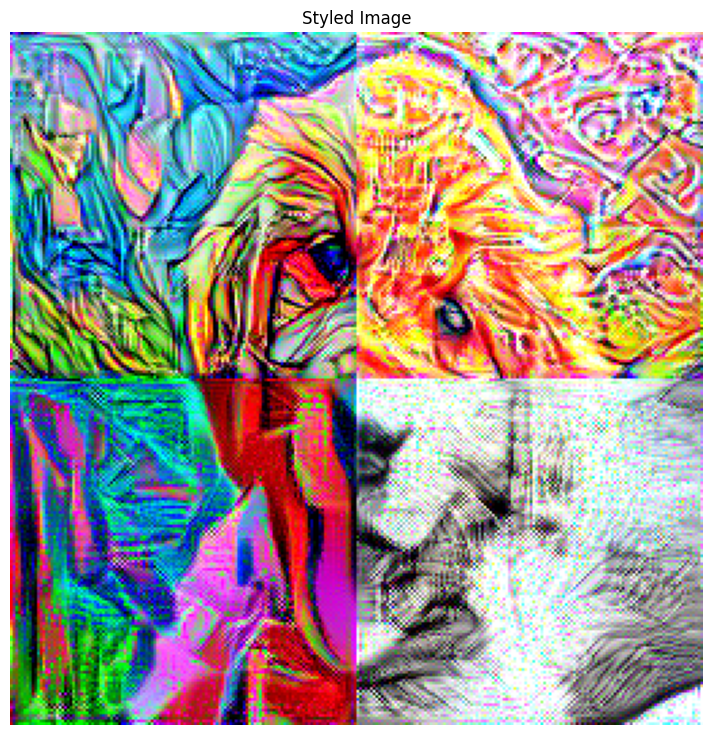

In [ ]:

# Display the images in the notebook
plt.figure(figsize=(9, 9))
plt.imshow(final_image)
plt.axis('off')
plt.title('Styled Image')
plt.show()
